In [1]:
# libabries for data exploration.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helpful_functions import MLFunctions

# time series specific libararies
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.offsetbox import AnchoredText
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [2]:
# load sales data.
sales = pd.read_csv("../../../Data/future_sales/sales_train.csv",
                    usecols=['date', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'],
                    index_col=['date'], 
                    parse_dates=['date'],
                    date_format="%d.%m.%Y")

In [3]:
sales = sales.sort_index()
helper_function = MLFunctions(sales)
arr = helper_function.dateNum()
sales['time'] = arr

In [4]:
date_shop_sum = sales.groupby(['date','shop_id']).sum()[['item_cnt_day']]
date_shop_count = sales.groupby(['date','shop_id']).nunique()[['item_id']]
date_shop_mean = sales.groupby(['date','shop_id']).mean()[['item_price']]
date_shop_median = sales.groupby(['date','shop_id']).median()[['time']]
sales_agg = pd.concat([date_shop_sum, date_shop_count, date_shop_mean, date_shop_median], axis=1)

In [5]:
sales_agg = sales_agg.reset_index()
sales_agg.index = sales_agg['date']

<Axes: xlabel='time'>

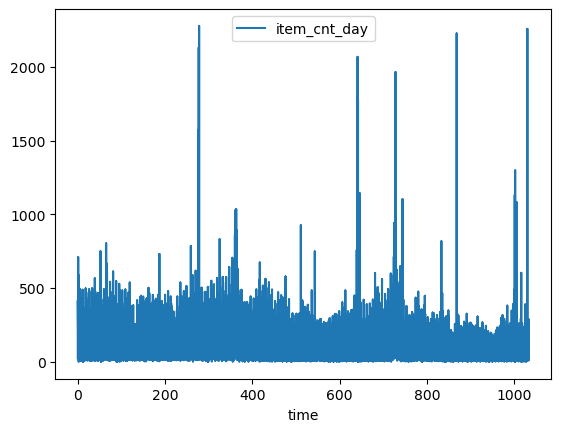

In [6]:
sales_agg.plot(kind='line', x='time', y='item_cnt_day')

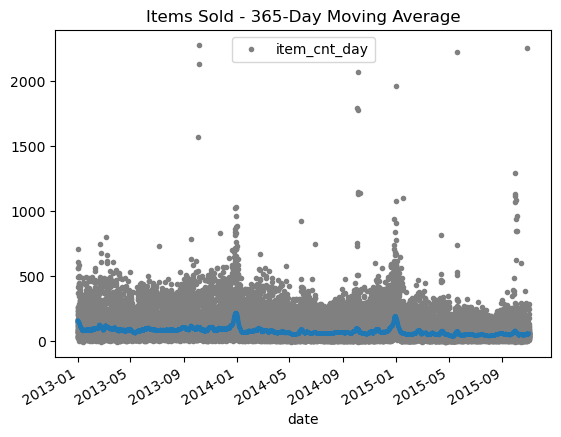

In [7]:
moving_average = sales_agg[['item_cnt_day']].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = sales_agg[['item_cnt_day']].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Items Sold - 365-Day Moving Average", legend=False,
);

<Axes: xlabel='time'>

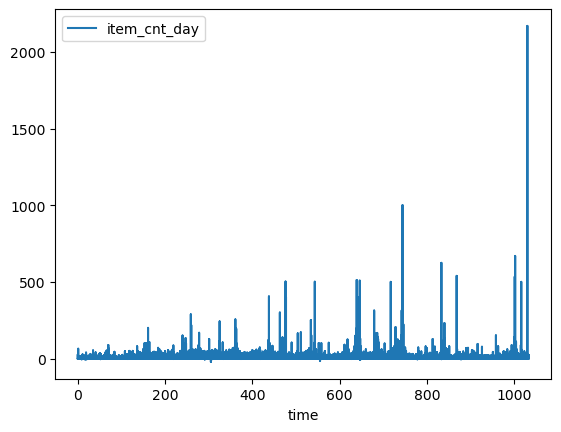

In [8]:
sales.plot(kind='line', x='time', y='item_cnt_day')

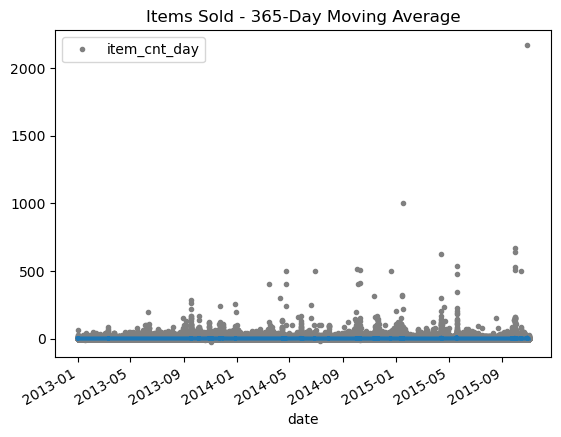

In [9]:
moving_average = sales[['item_cnt_day']].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = sales[['item_cnt_day']].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Items Sold - 365-Day Moving Average", legend=False,
);

<Axes: xlabel='time'>

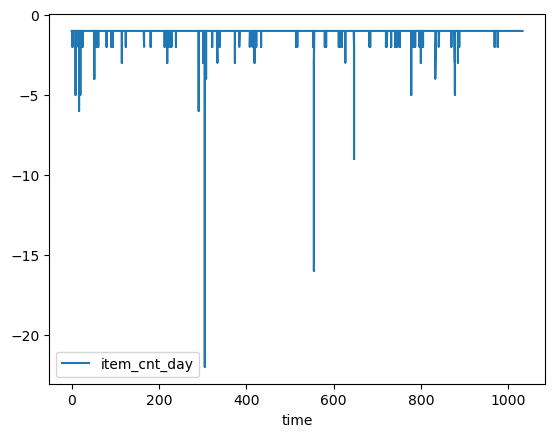

In [10]:
sales.loc[sales['item_cnt_day']<0, :].plot(x='time', y='item_cnt_day')

In [439]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=90,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

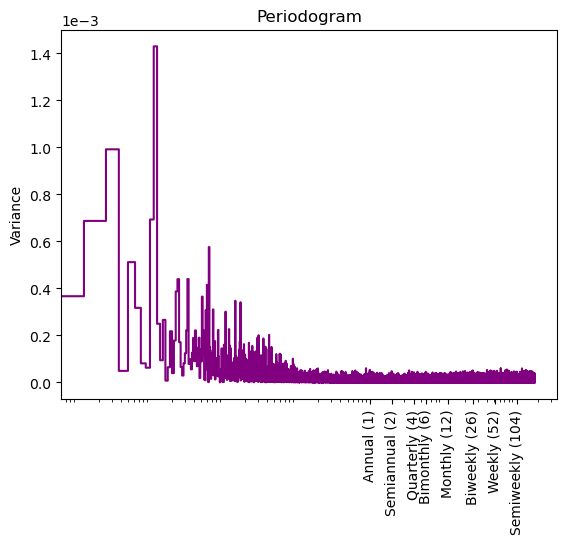

In [441]:
plot_periodogram(sales.item_cnt_day)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

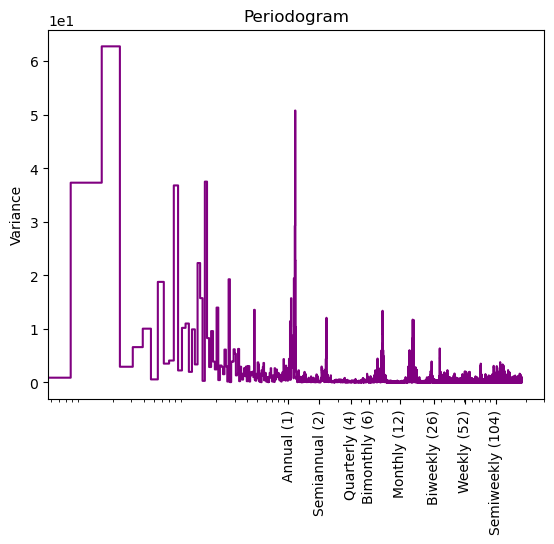

In [443]:
plot_periodogram(sales_agg.item_cnt_day)

In [3]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        errorbar=('ci', False),
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [ ]:
X = sales.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="item_cnt_day", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="item_cnt_day", period="year", freq="dayofyear", ax=ax1);